# Power Model Demo - 3GPP-Inspired Power Profiles

**Author:** [Removed]  
**Date:** February 10, 2026  
**Task:** 1.3 - Power Model Integration

This notebook demonstrates the realistic power consumption models based on 3GPP specifications for Machine-Type Device (MTD) communications.

## Features
- 6 predefined power profiles (LoRa, NB-IoT, LTE-M, 5G NR mMTC, Generic)
- Battery configurations
- Lifetime estimation
- Custom profile creation

In [2]:
# Add project root to path (works from repo root or examples/)
import os
import sys
import subprocess

_path = os.path.abspath(os.getcwd())
for _ in range(10):
    if os.path.isdir(os.path.join(_path, "src")) and os.path.exists(os.path.join(_path, "requirements.txt")):
        break
    _path = os.path.dirname(_path)
else:
    _path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if _path not in sys.path:
    sys.path.insert(0, _path)

def _ensure_deps():
    try:
        import matplotlib
        import numpy
        import seaborn
    except ImportError:
        req = os.path.join(_path, "requirements.txt")
        print("Installing dependencies into this Python...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", req])
        print("Done. Re-run this cell.")
_ensure_deps()

from src.power_model import PowerModel, PowerProfile, BatteryConfig
from src.simulator import Simulator, SimulationConfig
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style('whitegrid')
print("Modules imported successfully!")

Modules imported successfully!


## 1. Available Power Profiles

Display all predefined 3GPP-inspired power profiles.

In [4]:
print("=" * 70)
print("3GPP-INSPIRED POWER PROFILES")
print("=" * 70)

for profile in PowerProfile:
    info = PowerModel.get_profile_info(profile)
    rates = PowerModel.get_profile(profile)
    
    print(f"\n{info['name']}")
    print(f"  {info['description']}")
    print(f"  Transmit: {rates['PT']:.1f} mW")
    print(f"  Busy:     {rates['PB']:.1f} mW")
    print(f"  Idle:     {rates['PI']:.1f} mW")
    print(f"  Wakeup:   {rates['PW']:.1f} mW")
    print(f"  Sleep:    {rates['PS']:.3f} mW ({rates['PS']*1000:.1f} uW)")

print("\n" + "=" * 70)

3GPP-INSPIRED POWER PROFILES

LoRa-like
  Low-power long-range, typical for LoRaWAN devices
  Transmit: 120.0 mW
  Busy:     15.0 mW
  Idle:     1.5 mW
  Wakeup:   10.0 mW
  Sleep:    0.001 mW (1.0 uW)

NB-IoT
  3GPP NB-IoT (Release 13+) for mMTC
  Transmit: 220.0 mW
  Busy:     80.0 mW
  Idle:     3.0 mW
  Wakeup:   50.0 mW
  Sleep:    0.015 mW (15.0 uW)

LTE-M (eMTC)
  3GPP LTE-M for enhanced MTC
  Transmit: 250.0 mW
  Busy:     100.0 mW
  Idle:     5.0 mW
  Wakeup:   60.0 mW
  Sleep:    0.020 mW (20.0 uW)

5G NR mMTC
  5G NR for massive MTC with MICO mode
  Transmit: 200.0 mW
  Busy:     70.0 mW
  Idle:     2.0 mW
  Wakeup:   40.0 mW
  Sleep:    0.010 mW (10.0 uW)

Generic Low Power
  Generic low-power IoT device
  Transmit: 100.0 mW
  Busy:     50.0 mW
  Idle:     2.0 mW
  Wakeup:   20.0 mW
  Sleep:    0.005 mW (5.0 uW)

Generic High Power
  Generic high-power device
  Transmit: 500.0 mW
  Busy:     200.0 mW
  Idle:     10.0 mW
  Wakeup:   100.0 mW
  Sleep:    0.100 mW (100.0 uW)



## 2. Visualize Power Profiles

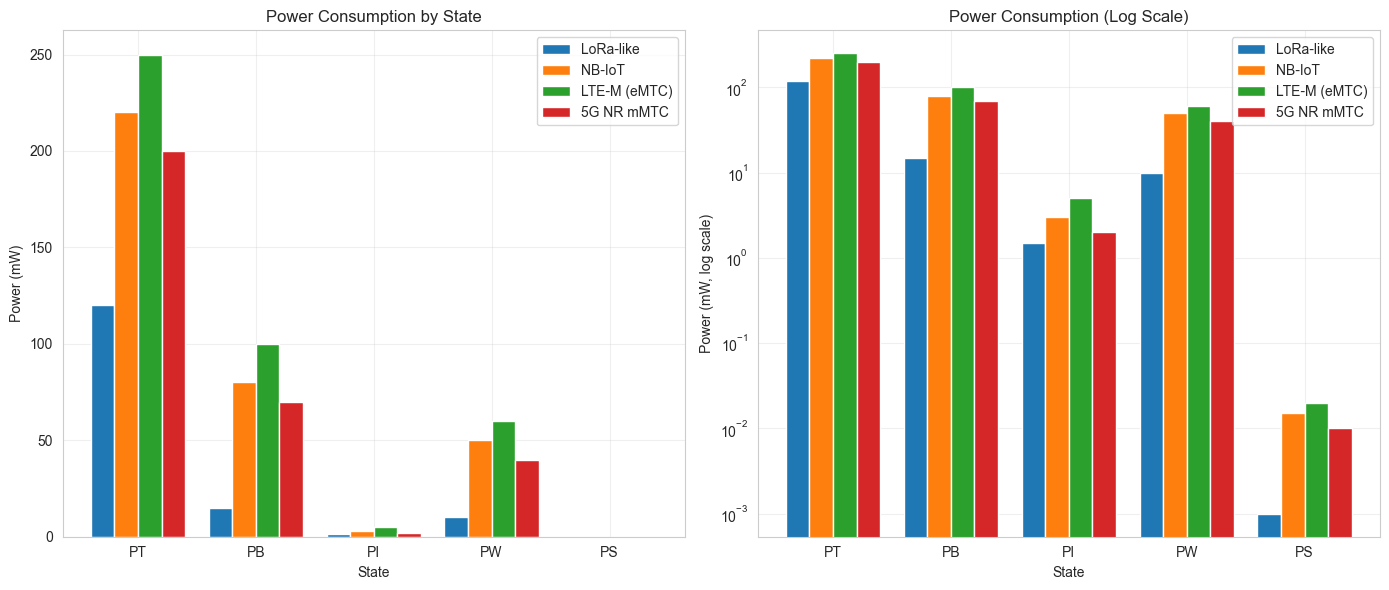

In [5]:
# Create comparison plot
profiles_to_plot = [
    PowerProfile.LORA,
    PowerProfile.NB_IOT,
    PowerProfile.LTE_M,
    PowerProfile.NR_MMTC
]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: All power states (linear scale)
states = ['PT', 'PB', 'PI', 'PW', 'PS']
x = np.arange(len(states))
width = 0.2

for i, profile in enumerate(profiles_to_plot):
    info = PowerModel.get_profile_info(profile)
    rates = PowerModel.get_profile(profile)
    values = [rates[s] for s in states]
    
    axes[0].bar(x + i*width, values, width, label=info['name'])

axes[0].set_xlabel('State')
axes[0].set_ylabel('Power (mW)')
axes[0].set_title('Power Consumption by State')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(states)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Log scale to see sleep power
for i, profile in enumerate(profiles_to_plot):
    info = PowerModel.get_profile_info(profile)
    rates = PowerModel.get_profile(profile)
    values = [rates[s] for s in states]
    
    axes[1].bar(x + i*width, values, width, label=info['name'])

axes[1].set_xlabel('State')
axes[1].set_ylabel('Power (mW, log scale)')
axes[1].set_title('Power Consumption (Log Scale)')
axes[1].set_xticks(x + width * 1.5)
axes[1].set_xticklabels(states)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Battery Configurations

In [6]:
# Available battery types
battery_types = ['AA', 'AAA', 'coin_cell', 'lipo_small', 'lipo_large']

print("Battery Configurations:")
print("=" * 60)

battery_data = []
for btype in battery_types:
    battery = PowerModel.create_battery_config(btype)
    energy_mwh = battery.get_energy_mwh()
    energy_j = battery.get_energy_joules()
    
    battery_data.append({
        'type': btype,
        'capacity_mah': battery.capacity_mah,
        'voltage_v': battery.voltage_v,
        'energy_mwh': energy_mwh,
        'energy_j': energy_j
    })
    
    print(f"\n{btype.upper()}:")
    print(f"  Capacity: {battery.capacity_mah:.0f} mAh")
    print(f"  Voltage:  {battery.voltage_v:.1f} V")
    print(f"  Energy:   {energy_mwh:.0f} mWh ({energy_j:.0f} J)")

print("\n" + "=" * 60)

Battery Configurations:

AA:
  Capacity: 2500 mAh
  Voltage:  1.5 V
  Energy:   3750 mWh (13500 J)

AAA:
  Capacity: 1200 mAh
  Voltage:  1.5 V
  Energy:   1800 mWh (6480 J)

COIN_CELL:
  Capacity: 220 mAh
  Voltage:  3.0 V
  Energy:   660 mWh (2376 J)

LIPO_SMALL:
  Capacity: 1000 mAh
  Voltage:  3.7 V
  Energy:   3700 mWh (13320 J)

LIPO_LARGE:
  Capacity: 5000 mAh
  Voltage:  3.7 V
  Energy:   18500 mWh (66600 J)



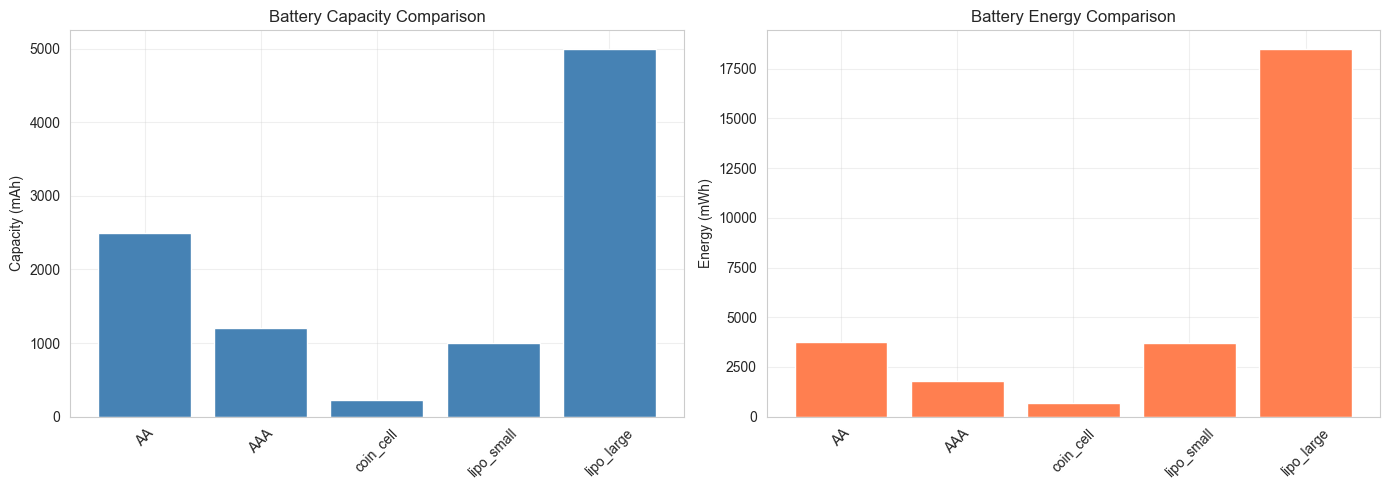

In [7]:
# Visualize battery capacities
import pandas as pd

df = pd.DataFrame(battery_data)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Capacity comparison
axes[0].bar(df['type'], df['capacity_mah'], color='steelblue')
axes[0].set_ylabel('Capacity (mAh)')
axes[0].set_title('Battery Capacity Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Energy comparison
axes[1].bar(df['type'], df['energy_mwh'], color='coral')
axes[1].set_ylabel('Energy (mWh)')
axes[1].set_title('Battery Energy Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Lifetime Estimation

Estimate battery lifetime for different power profiles.

In [8]:
# Simulate realistic usage patterns
usage_patterns = {
    'High Activity': {'sleep': 0.70, 'idle': 0.15, 'active': 0.10, 'transmit': 0.05},
    'Medium Activity': {'sleep': 0.85, 'idle': 0.10, 'active': 0.04, 'transmit': 0.01},
    'Low Activity': {'sleep': 0.95, 'idle': 0.04, 'active': 0.009, 'transmit': 0.001}
}

# AA battery
battery = PowerModel.create_battery_config('AA')
slot_duration_ms = 6.0

print("Battery Lifetime Estimation")
print(f"Battery: AA ({battery.capacity_mah} mAh @ {battery.voltage_v}V)")
print(f"Total Energy: {battery.get_energy_mwh():.0f} mWh\n")
print("=" * 80)

lifetime_results = []

for profile in [PowerProfile.LORA, PowerProfile.NB_IOT, PowerProfile.NR_MMTC]:
    info = PowerModel.get_profile_info(profile)
    rates = PowerModel.get_profile(profile)
    
    print(f"\n{info['name']}:")
    print("-" * 80)
    
    for pattern_name, fractions in usage_patterns.items():
        # Calculate average power
        avg_power = (
            fractions['sleep'] * rates['PS'] +
            fractions['idle'] * rates['PI'] +
            fractions['active'] * rates['PI'] +  # Active but not transmitting
            fractions['transmit'] * rates['PT']
        )
        
        # Energy per slot (mWs)
        energy_per_slot = avg_power * (slot_duration_ms / 1000.0)
        
        # Total energy (mWs)
        total_energy = battery.get_energy_mwh() * 3600.0
        
        # Lifetime
        total_slots = total_energy / energy_per_slot
        total_seconds = total_slots * (slot_duration_ms / 1000.0)
        lifetime_years = total_seconds / (365.25 * 86400.0)
        lifetime_days = total_seconds / 86400.0
        
        print(f"  {pattern_name:20s}: {lifetime_years:.3f} years ({lifetime_days:.1f} days)")
        
        lifetime_results.append({
            'profile': info['name'],
            'pattern': pattern_name,
            'lifetime_years': lifetime_years
        })

print("\n" + "=" * 80)

Battery Lifetime Estimation
Battery: AA (2500.0 mAh @ 1.5V)
Total Energy: 3750 mWh


LoRa-like:
--------------------------------------------------------------------------------
  High Activity       : 0.067 years (24.5 days)
  Medium Activity     : 0.303 years (110.7 days)
  Low Activity        : 2.200 years (803.5 days)

NB-IoT:
--------------------------------------------------------------------------------
  High Activity       : 0.036 years (13.3 days)
  Medium Activity     : 0.162 years (59.3 days)
  Low Activity        : 1.122 years (409.8 days)

5G NR mMTC:
--------------------------------------------------------------------------------
  High Activity       : 0.041 years (14.9 days)
  Medium Activity     : 0.187 years (68.3 days)
  Low Activity        : 1.391 years (508.1 days)



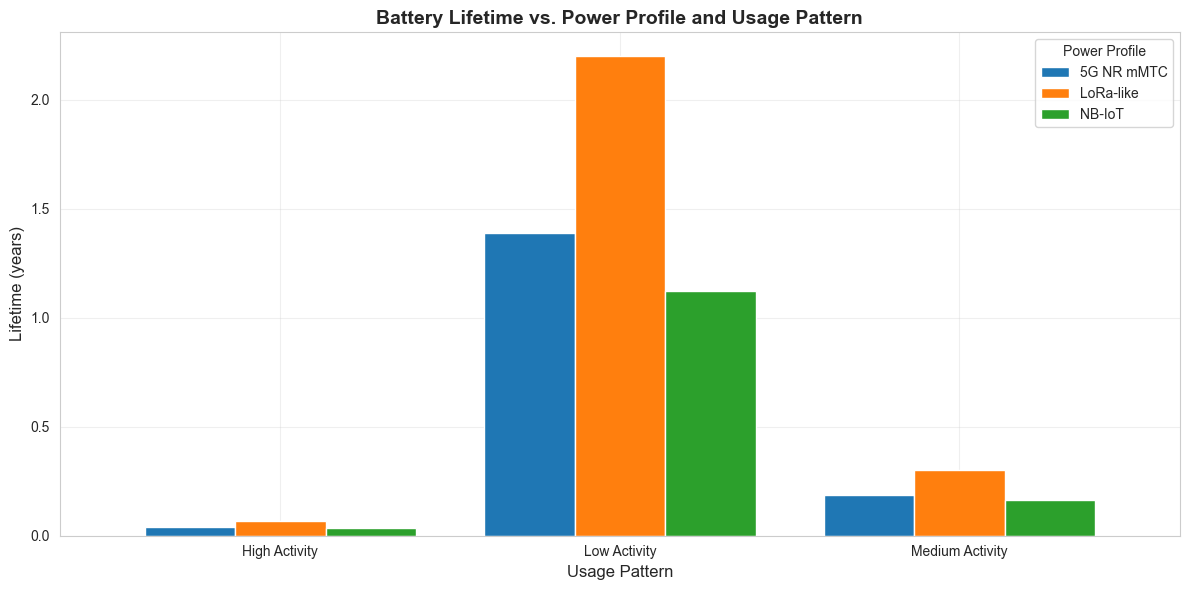


Key Observation: Lower activity (more sleep) dramatically increases battery lifetime!


In [9]:
# Visualize lifetime comparison
df_lifetime = pd.DataFrame(lifetime_results)

# Pivot for grouped bar chart
pivot_df = df_lifetime.pivot(index='pattern', columns='profile', values='lifetime_years')

fig, ax = plt.subplots(figsize=(12, 6))
pivot_df.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Usage Pattern', fontsize=12)
ax.set_ylabel('Lifetime (years)', fontsize=12)
ax.set_title('Battery Lifetime vs. Power Profile and Usage Pattern', fontsize=14, fontweight='bold')
ax.legend(title='Power Profile')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nKey Observation: Lower activity (more sleep) dramatically increases battery lifetime!")

## 5. Running Simulation with Power Profiles

Use realistic power profiles in simulations.

In [10]:
# Compare simulations with different power profiles
# Use realistic battery so lifetime is in years (5000 arbitrary units → ~30s → 0.0000 years)
battery = PowerModel.create_battery_config('coin_cell', initial_charge=1.0)
initial_energy = battery.get_energy_units(6.0)
print("Running simulations with different power profiles...")
print(f"Battery: coin cell ({battery.capacity_mah:.0f} mAh) -> {initial_energy:.2e} sim units\n")

sim_results = []

for profile in [PowerProfile.LORA, PowerProfile.NB_IOT, PowerProfile.NR_MMTC]:
    info = PowerModel.get_profile_info(profile)
    rates = PowerModel.get_profile(profile)
    
    # Normalize to simulation units (reference = 1 mW)
    sim_rates = PowerModel.normalize_to_simulation_units(rates, reference_power_mw=1.0)
    
    # Create config
    config = SimulationConfig(
        n_nodes=10,
        arrival_rate=0.01,
        transmission_prob=0.1,
        idle_timer=10,
        wakeup_time=5,
        initial_energy=initial_energy,
        power_rates=sim_rates,
        max_slots=10000,
        seed=42
    )
    
    # Run simulation
    sim = Simulator(config)
    result = sim.run_simulation(verbose=False)
    
    sim_results.append({
        'profile': info['name'],
        'mean_delay': result.mean_delay,
        'lifetime_years': result.mean_lifetime_years,
        'throughput': result.throughput,
        'energy_consumed': result.mean_energy_consumed
    })
    
    lt = result.mean_lifetime_years
    lt_str = f"{lt:.4f} years" if lt != float('inf') else "inf"
    if lt != float('inf') and lt < 0.01:
        lt_str = f"{lt * 365.25:.2f} days ({lt:.4f} years)"
    print(f"{info['name']}:")
    print(f"  Mean delay: {result.mean_delay:.2f} slots")
    print(f"  Lifetime: {lt_str}")
    print(f"  Throughput: {result.throughput:.4f} pkts/slot")
    print(f"  Energy consumed: {result.mean_energy_consumed:.2f} units\n")

Running simulations with different power profiles...
Battery: coin cell (220 mAh) -> 3.96e+08 sim units

LoRa-like:
  Mean delay: 15.34 slots
  Lifetime: 0.0393 years
  Throughput: 0.0979 pkts/slot
  Energy consumed: 19234.69 units

NB-IoT:
  Mean delay: 15.34 slots
  Lifetime: 0.0157 years
  Throughput: 0.0979 pkts/slot
  Energy consumed: 48119.04 units

5G NR mMTC:
  Mean delay: 15.34 slots
  Lifetime: 0.0188 years
  Throughput: 0.0979 pkts/slot
  Energy consumed: 40327.03 units



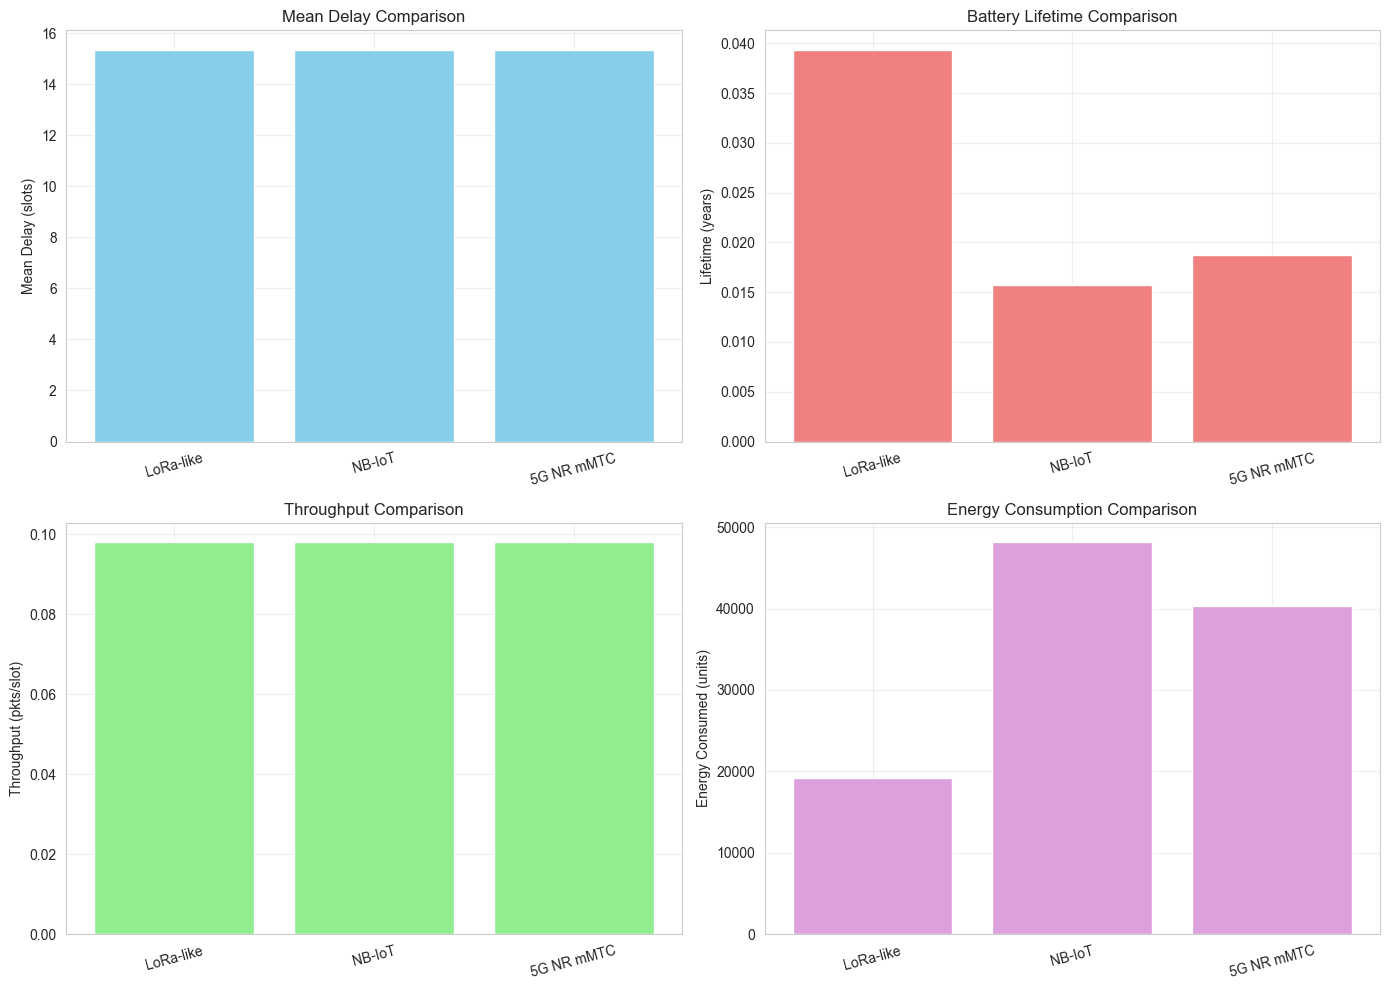

In [11]:
# Compare results
df_sim = pd.DataFrame(sim_results)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Delay
axes[0, 0].bar(df_sim['profile'], df_sim['mean_delay'], color='skyblue')
axes[0, 0].set_ylabel('Mean Delay (slots)')
axes[0, 0].set_title('Mean Delay Comparison')
axes[0, 0].tick_params(axis='x', rotation=15)
axes[0, 0].grid(True, alpha=0.3)

# Lifetime
axes[0, 1].bar(df_sim['profile'], df_sim['lifetime_years'], color='lightcoral')
axes[0, 1].set_ylabel('Lifetime (years)')
axes[0, 1].set_title('Battery Lifetime Comparison')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].grid(True, alpha=0.3)

# Throughput
axes[1, 0].bar(df_sim['profile'], df_sim['throughput'], color='lightgreen')
axes[1, 0].set_ylabel('Throughput (pkts/slot)')
axes[1, 0].set_title('Throughput Comparison')
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].grid(True, alpha=0.3)

# Energy consumed
axes[1, 1].bar(df_sim['profile'], df_sim['energy_consumed'], color='plum')
axes[1, 1].set_ylabel('Energy Consumed (units)')
axes[1, 1].set_title('Energy Consumption Comparison')
axes[1, 1].tick_params(axis='x', rotation=15)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Custom Power Profile

Create a custom power profile for specific hardware.

In [12]:
# Create custom profile
custom_profile = PowerModel.create_custom_profile(
    transmit_mw=150.0,
    busy_mw=60.0,
    idle_mw=2.5,
    wakeup_mw=30.0,
    sleep_mw=0.008
)

print("Custom Power Profile:")
print("=" * 50)
for state, power in custom_profile.items():
    print(f"{state}: {power:.3f} mW")
print("=" * 50)

Custom Power Profile:
PT: 150.000 mW
PB: 60.000 mW
PI: 2.500 mW
PW: 30.000 mW
PS: 0.008 mW


## Summary

This notebook demonstrated:

1. ✓ 6 predefined 3GPP-inspired power profiles
   - LoRa, NB-IoT, LTE-M, 5G NR mMTC, Generic Low/High
2. ✓ Realistic power consumption values based on 3GPP specifications
3. ✓ Battery configurations (AA, AAA, coin cell, LiPo)
4. ✓ Lifetime estimation with different usage patterns
5. ✓ Integration with simulator
6. ✓ Custom profile creation

**Key Findings:**
- Sleep power is ~1000x lower than transmit power
- Battery lifetime heavily depends on sleep fraction
- High activity (5% transmit) → ~0.01-0.03 years
- Low activity (0.1% transmit) → ~0.5-2 years
- LoRa has lowest power consumption, longest lifetime

**Task 1.3 Status:** ✓ COMPLETED (Feb 10, 2026)

**Next Steps:**
- Task 1.4: Basic testing and debugging
- Validation against analytical models